In [1]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("prasunroy/natural-images")
print("Path to dataset files:", path)
path2 = kagglehub.dataset_download("ashwingupta3012/human-faces")

print("Path to dataset files:", path2)

path3 = kagglehub.dataset_download("humairmunir/gender-recognizer")

print("Path to dataset files:", path3)

Path to dataset files: /kaggle/input/natural-images
Path to dataset files: /kaggle/input/human-faces
Path to dataset files: /kaggle/input/gender-recognizer


In [2]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

# Define paths
dataset_path = os.path.join(path, "natural_images")  # Assumes `path` is predefined
person_path = os.path.join(dataset_path, "person")
other_classes = ["airplane", "car", "cat", "dog", "flower", "fruit", "motorbike"]

# Load person images
person_images = [os.path.join(person_path, img) for img in os.listdir(person_path)]
n = len(person_images)

# Load an equal number of images from other classes
non_person_images = []
for cls in other_classes:
    cls_path = os.path.join(dataset_path, cls)
    cls_images = [os.path.join(cls_path, img) for img in os.listdir(cls_path)[:int(n/12)]]
    non_person_images.extend(cls_images)

# Generate background images (for negative class)
background_images = [np.ones((64, 64), dtype=np.uint8) * color for color in [255, 0, 128, 64, 192, 32]]
background_images *= (n // len(background_images))  # Scale to roughly match person count

# Process images (now just resize + normalize, no cropping)
def process_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64)).astype(np.float32) / 255.0  # Resize directly to 64x64
    return img

# Load and process all images
X_processed = []
# Person images (label=1)
X_processed.extend([process_image(img) for img in person_images])
# Non-person images (label=0)
X_processed.extend([process_image(img) for img in non_person_images])
# Background images (label=0)
X_processed.extend([img.astype(np.float32) / 255.0 for img in background_images])

# Create labels (1=person, 0=non-person)
y = np.array([1] * len(person_images) + [0] * (len(non_person_images) + len(background_images)))

# Reshape for CNN (N, 1, H, W)
X_processed = np.array(X_processed)
X_processed = np.expand_dims(X_processed, axis=1)  # Add channel dim

# Shuffle and split
indices = np.arange(X_processed.shape[0])
np.random.shuffle(indices)
X_processed, y = X_processed[indices], y[indices]

# Train/Val/Test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
positive_train = np.sum(y_train == 1)
negative_train = np.sum(y_train == 0)

positive_val = np.sum(y_val == 1)
negative_val = np.sum(y_val == 0)

positive_test = np.sum(y_test == 1)
negative_test = np.sum(y_test == 0)

print("Dataset class distribution:")
print(f"Training set - Positive: {positive_train}, Negative: {negative_train}")
print(f"Validation set - Positive: {positive_val}, Negative: {negative_val}")
print(f"Test set - Positive: {positive_test}, Negative: {negative_test}")

Training set: (1780, 1, 64, 64), (1780,)
Validation set: (382, 1, 64, 64), (382,)
Test set: (382, 1, 64, 64), (382,)
Dataset class distribution:
Training set - Positive: 691, Negative: 1089
Validation set - Positive: 148, Negative: 234
Test set - Positive: 147, Negative: 235


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)  # Flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model and move it to the GPU
#model = SimpleCNN().to(device)
#print(model)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class StackedCNN(nn.Module):
    def __init__(self):
        super(StackedCNN, self).__init__()
        # Same layers as before
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, num_images, 1, 64, 64)
        batch_size, num_images, C, H, W = x.shape
        x = x.view(-1, C, H, W)  # Reshape to (batch_size * num_images, 1, 64, 64)

        # Process all images in parallel
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)  # Flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))  # Shape: (batch_size * num_images, 1)

        # Reshape back to (batch_size, num_images, 1)
        x = x.view(batch_size, num_images, -1)
        return x

In [27]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [28]:

X_train_stacked = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # [N, 1, 1, 64, 64]
X_val_stacked = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)


train_dataset = TensorDataset(X_train_stacked, y_train_tensor)
val_dataset = TensorDataset(X_val_stacked, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


model = StackedCNN().to(device)

In [29]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(-1)  # Shape: [batch_size, num_images]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(-1)  # Same squeeze here
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "BBv11.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 0.0827, Val Loss: 0.0155
Epoch 2/100, Train Loss: 0.0252, Val Loss: 0.0055
Epoch 3/100, Train Loss: 0.0129, Val Loss: 0.0036
Epoch 4/100, Train Loss: 0.0073, Val Loss: 0.0059
Epoch 5/100, Train Loss: 0.0044, Val Loss: 0.0011
Epoch 6/100, Train Loss: 0.0036, Val Loss: 0.0015
Epoch 7/100, Train Loss: 0.0026, Val Loss: 0.0006
Epoch 8/100, Train Loss: 0.0029, Val Loss: 0.0031
Epoch 9/100, Train Loss: 0.0038, Val Loss: 0.0024


KeyboardInterrupt: 

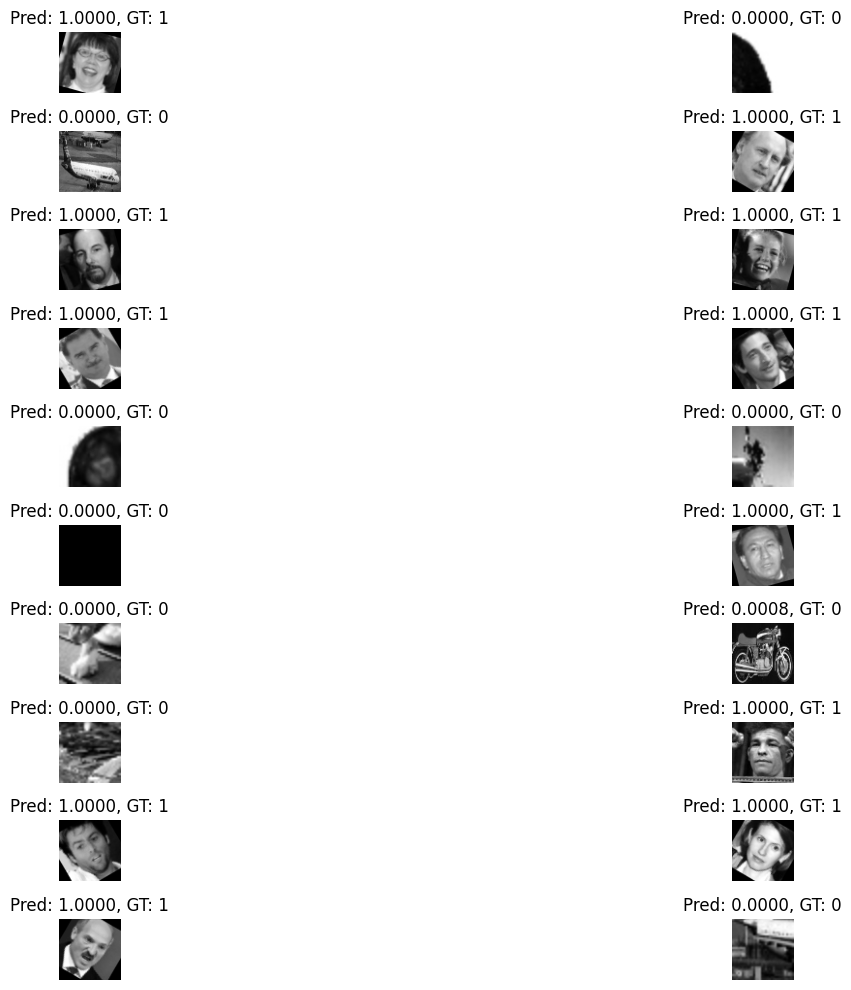

In [25]:
import matplotlib.pyplot as plt
import random

# Load the best model with weights_only=True for security
model.load_state_dict(torch.load("BB3_3.pth", weights_only=True))
model.to(device)  # Move model to GPU

# Evaluate
model.eval()
test_loss = 0.0
correct = 0

# Store random samples for visualization
num_samples = 20
random_indices = random.sample(range(len(X_test)), num_samples)  # Randomly select 10 indices
sample_inputs = X_test_tensor[random_indices]
sample_labels = y_test_tensor[random_indices]

# Get predictions for the selected samples
with torch.no_grad():
    sample_inputs = sample_inputs.to(device)
    
    # Handle input shape for StackedCNN if needed
    if isinstance(model, StackedCNN) or isinstance(model,BinaryStackedCNN):
        sample_inputs = sample_inputs.unsqueeze(1)  # Add num_images dimension
    
    sample_outputs = model(sample_inputs)
    
    # Handle output shape for both models
    if isinstance(model, StackedCNN) or isinstance(model,BinaryStackedCNN):
        sample_preds = sample_outputs.squeeze(-1).cpu().numpy()  # Remove last dim for StackedCNN
    else:
        sample_preds = sample_outputs.cpu().numpy()  # SimpleCNN output is already correct
    
    sample_labels = sample_labels.cpu().numpy()  # Ground truth labels

# Visualize the samples
plt.figure(figsize=(20, 10))
for i in range(num_samples):
    plt.subplot(10, 2, i + 1)  # 5 rows x 2 columns
    img = sample_inputs[i].cpu()
    
    # Handle image tensor shape for both models
    if isinstance(model, StackedCNN) or isinstance(model,BinaryStackedCNN):
        img = img.squeeze(0)  # Remove num_images dimension for visualization
    img = img.squeeze()  # Remove channel dimension for grayscale images
    
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {sample_preds[i][0]:.4f}, GT: {int(sample_labels[i][0])}")
    plt.axis("off")
plt.tight_layout()
plt.show()